In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# Assessing Predictive Power with the Information Coefficient
The first step, when we want to **assess the quality of a predictive information signal**, is to perform a **statistical analysis** of the correlation between the value of the signal today and the future returns of the asset. As an example, here we will test the validity of a **value** strategy in the US stock market.

From your previous studies you know that **linear regressions** are a simple and straightforward way to test for the existence of a predictive relationship. We could simply regress the future return of all stocks on the historical E/P ratio.

$$ r_{i, t+1} = \alpha + \beta \frac{E}{P}_{i,t} + \epsilon $$


The problem with linear regressions is they are also **very demanding on our data**: not only we look for a relationship, but for a _linear one!_

The picture below shows an example of an interesting predictive relationship between Variable 1 and Varaible 2. Clearly the two variables are related, but in a non-linear way!

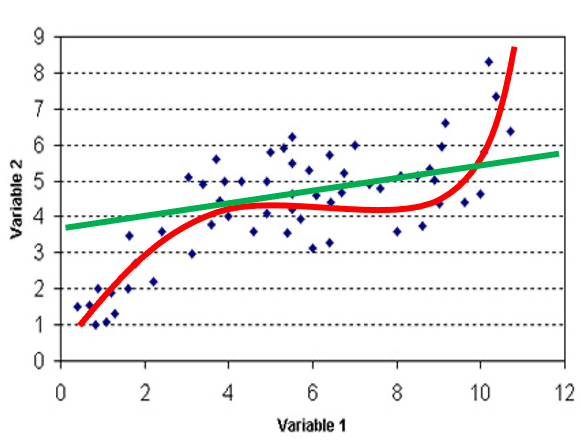

If we try to fit a linear regression (green line), the result will be a flat/weak relationship. This is because **the predictive power of Variable 1 is limited to its extreme values**: If Var 1 is "very high", then Var 2 will be higher than the average, if Var 2 is "very low", then Var 2 will be lower than the average.

This result is **very valuable in investment terms** but we would completely miss it with a simple linear analysis. Here we will try to remedy this problem with a **non-linear approach** to testing the existence of a relationship between our predicitve factor and the future returns.

___
## 1. The Data
Let's start by loading our data on returns and historical betas. In this case we are going to use some **zipped csv** files prepared for this subject containing monthly observations on all the **US stocks from 1980**.

In [2]:
returns = pd.read_csv('Returns.zip', parse_dates=['date']).set_index(['id', 'date'])
returns.head()

return
id    date                
10000 1986-01-31  0.000000
      1986-02-28 -0.297252
      1986-03-31  0.311436
      1986-04-30 -0.103797
      1986-05-30 -0.251873

In [3]:
signal = pd.read_csv('EPQ.zip', parse_dates=['date']).set_index(['id', 'date']) #EPQ is the E/P ratio calcualted with quarterly earnings
signal.head()

epq
id    date                
10001 1986-11-28 -0.346658
      1986-12-31 -0.246254
      1987-01-30 -0.326536
      1987-02-27  0.418686
      1987-03-31  0.410622

As we can see we have an identification code for the stocks (`id`), a date and our variables of interest. It is common to use numerical identification codes for stocks because names often change. In this case we are using the permno from the CRSP database of the Unviersity of Chicago.

We immediately notice that we **do not have the same observations** for all the variables, for example we are missing observations on the information signal of the stock `10000`. We will have to deal with this problem in a moment.

Our first concern is to create a series with the _"future returns"_ that we can match with the information signal.

Notice that we have to use the [**`DataFrame.groupby()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) operator because we want to shift by one month **within each stock**. 

Let's now join the two objects.

In [5]:
data = signal.join(future_returns).dropna()
data.head()

epq   fut_ret
id    date                          
10001 1986-11-28 -0.346658  0.014889
      1986-12-31 -0.246254 -0.036368
      1987-01-30 -0.326536 -0.076961
      1987-02-27  0.418686  0.036139
      1987-03-31  0.410622 -0.040005

Here we can use [**`DataFrame.join()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) because we are merging on the index (`id` and `date`) rather than on common columns. The final [**`DataFrame.dropna()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) is to be sure that we do not have any missing value in our final DataFrame.

___
## 2. Information Coefficient Analysis
A first statistic that we want to analyze is the [information coefficient](https://en.wikipedia.org/wiki/Information_coefficient). This refers generally to the ability to predict something, and can be calculated in different ways. It is normally defined on a scale between 0 and 1, with 1 meaning infallible predictive power. Here we will use the **rank correlation** between the information signal and the future returns. This is a form of correlation that only looks at the ranking: for example if we have that $x_{1} > x_{2} > x_{3}$ and $y_{1} > y_{2} > y_{3}$ than we will say that $x$ and $y$ are perfectly correlated: the ranking between the stocks is the same. This is called the [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) coefficient.

Pandas has built-in method [**`DataFrame.corr()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to calculate correlation coefficients between columns of a DataFrame.

In [6]:
data.corr(method='spearman')

,epq,fut_ret
epq,1.000000,0.075248
fut_ret,0.075248,1.000000


Here we see that the average relationship between 1980 and 2019 is positive but quite weak. But this is not exactly what we are looking for. The average return of the asset can change in time: all shares have higer return when the market goes up... This makes ranking observations of different periods together quite messy. Let's calculate **a different ranking for every month** using the `data.groupby('date')` operator.

In [7]:
ic = data.groupby('date').corr(method='spearman')
ic.head(10)

epq   fut_ret
date                                  
1980-01-31 epq      1.000000 -0.048070
           fut_ret -0.048070  1.000000
1980-02-29 epq      1.000000  0.188458
           fut_ret  0.188458  1.000000
1980-03-31 epq      1.000000  0.064272
           fut_ret  0.064272  1.000000
1980-04-30 epq      1.000000  0.085078
           fut_ret  0.085078  1.000000
1980-05-30 epq      1.000000  0.082193
           fut_ret  0.082193  1.000000

The result is a bit messy. This is because the output of the correlation function is a 2x2 table and when we stack them one on top of each other we get two lines for every date!

In order to recover the data we want we need to do a bit of **advanced slicing**. Remember that to slice a DataFrame we can use the **`.loc[]`** notation. The typical formulation is `DataFrame.loc[index values, column values]`. Here this is complicated by the fact that the index has two levels, so the slice becomes `DataFrame.loc[(index values level 0, index values level 1), column values]`. A second complication is that we do not want actually to slice for the first level of the index. So the command is:

In [8]:
ic = ic.loc[(slice(None),'epq'),'fut_ret']
ic.head()

date           
1980-01-31  epq   -0.048070
1980-02-29  epq    0.188458
1980-03-31  epq    0.064272
1980-04-30  epq    0.085078
1980-05-30  epq    0.082193
Name: fut_ret, dtype: float64

The `slice(None)` parameter indicates that we do not want to drop any value for the first level of the index (the dates) but we select only the `factor` for the second value of the index. Finally we only select the `fut_ret` column.

As a second step we want to **drop the second level of the index** because now it's useless.

In [9]:
ic = ic.droplevel(level=1)

Finally we want to **rename the series**. It currenty has inerited the name of the return series and it's a bit confusing.

In [10]:
ic = ic.rename('IC') # STEP 3: rename the column so we do not get confused on its content
ic.head()

date
1980-01-31   -0.048070
1980-02-29    0.188458
1980-03-31    0.064272
1980-04-30    0.085078
1980-05-30    0.082193
Name: IC, dtype: float64

Finally we have the result we wanted, but it took us three steps to get here! Luckily Python has something called [method chaining](https://www.kaggle.com/residentmario/method-chaining-reference). We can "chain" methods together, and reduce all the steps in a single line

In [11]:
ic = data.groupby('date').corr(method='spearman')

# HERE we do STEPS 1, 2 and 3 in the same line!
ic = ic.loc[(slice(None),'epq'),'fut_ret'].droplevel(level=1).rename('IC')

ic.head()

date
1980-01-31   -0.048070
1980-02-29    0.188458
1980-03-31    0.064272
1980-04-30    0.085078
1980-05-30    0.082193
Name: IC, dtype: float64

Let's look the average level of the IC:

In [12]:
ic.mean()

0.0815570301957259

Knowing that the average monthly IC is positive is already something. If we want to be more precise and rigorous, we should also test whether this average is [statistically different from zero](https://en.wikipedia.org/wiki/Student%27s_t-test#One-sample_t-test). 

We could code our own t-test but since we are lazy we decide to use a **built-in function** for this. We can find functions to perform statistical tests in different places in Python, but the default options is usually [**Scipy**](https://docs.scipy.org/doc/scipy/reference/), the last piece of our data science stack. Specifically we will use the **stats** sub-module and the [**`.ttest_1samp()`**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html) function.

In [13]:
from scipy import stats
test = stats.ttest_1samp(ic, 0)

From the new object we can simply extract the **t-stat** and the **p-value**.

In [14]:
test.statistic

18.65801405698159

In [15]:
test.pvalue

4.305319075811962e-59

Or, if we feel fancy, we can **print a string** with the commented result.

In [16]:
test = stats.ttest_1samp(ic, 0)
print('T-Stat:', round(test.statistic,3), 'P-Value:', round(test.pvalue,3))

T-Stat: 18.658 P-Value: 0.0


In any case, the t-test confirms that the relationship between E/P and future returns is, on average, **positive and statistically different from zero**.

So, it is clearly different from zero, on average. Another interesting aspect is to look at **how often it's positive vs negative**.

In [17]:
ic.apply(np.sign).value_counts() / ic.count()

 1.0    0.851324
-1.0    0.148676
Name: IC, dtype: float64

As we can see E/P is positively correlated with monthly future returns 85.1% of the months. We can finally **plot the Information Coefficient**.

<AxesSubplot:title={'center':'Information Coefficient'}, xlabel='date'>

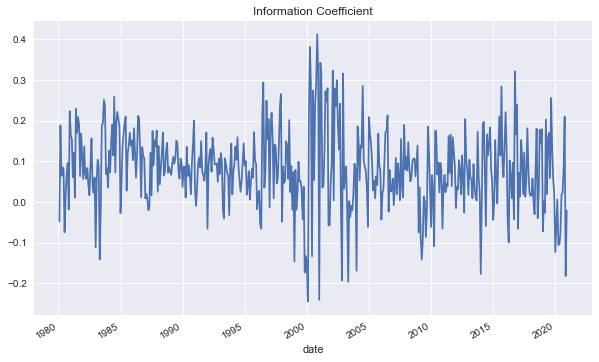

In [18]:
ic.plot(figsize=(10, 6),
        title='Information Coefficient')

Of course, looking at a strategy month by month can be misleading. Even if we care about the predictability of _monthly returns_, for example because we plan to rebalance the portfolio monthly, we may still be interested at the **average outcome after, let's say, 12 months of trading**.

Let's calculate the **12months rolling average IC**, this will give us the _average correlation_ between our information signal and monthly returns over the previous year. 

In [19]:
avg_ic = ic.rolling(12).mean().rename('Avg_IC')
avg_ic.tail()

date
2020-07-31    0.003778
2020-08-31   -0.010784
2020-09-30   -0.003931
2020-10-30   -0.023647
2020-11-30   -0.027277
Name: Avg_IC, dtype: float64

In [20]:
avg_ic.apply(np.sign).value_counts() / avg_ic.count()

 1.0    0.966667
-1.0    0.033333
Name: Avg_IC, dtype: float64

Now the picture is even clearer: if we follow this monthly strategy for one year, the probability of overperforming the market is 97%!

Let's plot the IC together with its moving average. It's easier to plot both series if we put them in the same DataFrame

<AxesSubplot:xlabel='date'>

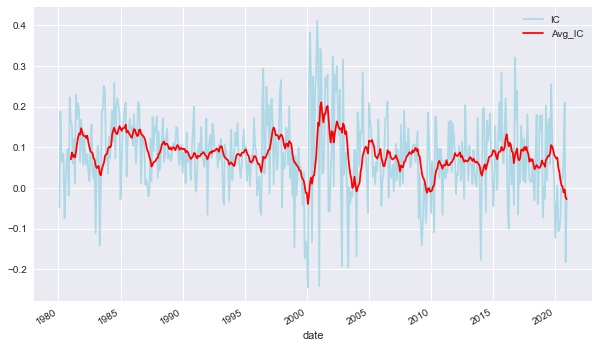

In [21]:
df = ic.to_frame().join(avg_ic)

df.plot(figsize=(10, 6),
        color={'IC':'lightblue', 'Avg_IC':'red'})

___
## 3. IC at longer horizons
We have so far tried to predict monthly returns. In the short run returns can be affected by a number of **uncorrelated shocks**. Sometimes increasing the horizon of our strategy, for example rebalancing every quarter or every year, can **improve predictability**. 

Let's see if the relationship holds at longer horizons, if there is any relationship between E/P and returns for the **next year**.

### 3.1 Calculating annual returns

Since our database contains **logarithmic returns** we can easily calculate the annual return as the **sum of the monthly returns**. You will notice that, in the code below, we use **`.rolling(12)`** to do a rolling sum of 12 monthly returns. Alas the rolling operator **can only go back in time** so in time $t$ we will get the sum of the returns from $t$ to $t-11$. We need to use the **`.shift(-11)`** operator to **move forward in time** and get the sum of the returns from $t$ to $t+11$. In the next line we then use the shift operator one more time to get the future annualized return (from $t+1$ to $t+12$). We could have combined these two lines in a single one, but for sake of readability of the code here I have kept them separate.

**ATTENTION:** The final `.set_index(returns.index)` in the first line is a technical issue related to Pandas. When we use `.rolling()` with a multiindex where we group by one level of the index, in the result we lose the other index level (the dates here). So we simply **assign again the original index**.

In [22]:
returns12 = returns.groupby('id').rolling(12).sum().shift(-11).set_index(returns.index)
future_returns12 = returns12.groupby('id')['return'].shift(-1).rename('fut_ret')
future_returns12.head()

id     date      
10000  1986-01-31   -2.376693
       1986-02-28   -2.079442
       1986-03-31   -2.876386
       1986-04-30   -2.837127
       1986-05-30   -2.654248
Name: fut_ret, dtype: float64

We can now join the future annual return with the E/P.

In [23]:
data12 = signal.join(future_returns12).dropna()
data12.head()

epq   fut_ret
id    date                          
10001 1986-11-28 -0.346658 -0.057779
      1986-12-31 -0.246254 -0.106778
      1987-01-30 -0.326536 -0.008535
      1987-02-27  0.418686  0.145387
      1987-03-31  0.410622  0.029884

Our data is almost ready for the analysis. There is one last consideration: from your basic knowledge of statistics you may remember that one of the key assumptions of many statistical calculations is that all the **observations are i.i.d.**, independent and identically distributed. Our observations **are clearly not independent**: we have monthly obervations of annual returns! The "Future Annual Return" of stock ABC in January 1995 is almost identical to the Future Annual Return of stock ABC in February 1995, they overlap for 11 months out of 12! 

To be statistically consistent we need to use, for every stock, **only one observation for every year**. Let's start by extracting the calendar month from the date column. Since we have a MultiIndex we need to use the method [**`Index.get_level_values()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.get_level_values.html) to extract the values of a specific level of the index (the `date` here). Since our second level of the index is a date (technically something called a [DateTimeIndex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html)) we can use the attribute [**`DatetimeIndex.month`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.month.html#pandas.DatetimeIndex.month) to extract the calendar month from the date.

In [24]:
data12['month'] = data12.index.get_level_values('date').month
data12.head()

epq   fut_ret  month
id    date                                 
10001 1986-11-28 -0.346658 -0.057779     11
      1986-12-31 -0.246254 -0.106778     12
      1987-01-30 -0.326536 -0.008535      1
      1987-02-27  0.418686  0.145387      2
      1987-03-31  0.410622  0.029884      3

we can now extract all the observations where the month is equal to `12`, December. We overwrite the original DataFrame because we will never need the other observations again. Of course we could decide to create a new DataFrame called `december`.

In [25]:
data12 = data12[data12['month']==12]
data12.head()

epq   fut_ret  month
id    date                                 
10001 1986-12-31 -0.246254 -0.106778     12
      1987-12-31 -0.274453  0.151140     12
      1989-12-29  0.012253 -0.008759     12
      1990-12-31  0.037745  0.474662     12
      1991-12-31  0.058387  0.012541     12

Now that we have a DataFrame with **yearly observations** we can run our analysis.

### 3.2 Annual IC Analysis
Let's now quickly repeat the analysis at the annual level

In [26]:
ic12 = data12.groupby('date').corr(method='spearman')
ic12 = ic12.loc[(slice(None),'epq'),'fut_ret'].droplevel(level=1).rename('IC')
ic12.head()

date
1980-12-31    0.319429
1981-12-31    0.112603
1982-12-31    0.100832
1983-12-30    0.346851
1984-12-31    0.214430
Name: IC, dtype: float64

From the analysis below we see that **predictability of annual returns is significantly stronger**. The IC is on average much stronger and positive 90% of the times

In [27]:
ic12.mean()

0.133834806133015

In [28]:
ic12.apply(np.sign).value_counts() / ic12.count()

 1.0    0.9
-1.0    0.1
Name: IC, dtype: float64

In [29]:
t_test = stats.ttest_1samp(ic12, 0)
print('T-Stat:', round(t_test.statistic,3), 'P-Value:', round(t_test.pvalue,3))

T-Stat: 6.843 P-Value: 0.0


<AxesSubplot:title={'center':'Annual Analysis'}, xlabel='date'>

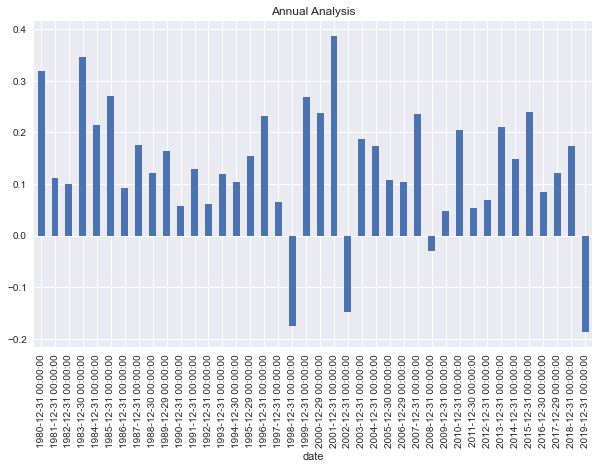

In [30]:
ic12.plot(kind='bar',
          figsize=(10, 6),
          title='Annual Analysis',
          legend=False)

___
## 4. Putting our IC Analysis in production
In the typical workflow of a quant, once we have established an analysis that works well for us, and that we may want to apply to a variety of contexts, for example to multiple factors, it is common to **encapsulate all the necessary code in a ready-to-use function** that we can easily apply multiple times without having to repeat the coding from scratch. 

Below you will find a function that incapsulate all the code written here above. **We will not build the function together**, but you are free to go into the function and read the comments to see how the function has been built. You will be able to **copy and use this function in your assignments** without having to modify it.

In [31]:
def ic_analysis(signal, returns, frequency='monthly'):
    
    #We load all the modules needed in the function just in case they are not loaded in the notebook.
    #They are only active within the function, if you need them elsewhere in the notebook you need to 
    #import them again in the notebook
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    #We check that the frequency is correct. If not we stop the function and return an empty result
    if frequency not in ['monthly', 'quarterly', 'annual']:
        print('Warning, the frequency must be monthly, quarterly or annual')
        return None
    
    #We capture the name of the factor using the .name attribute to use it later
    signal_name = signal.name
    
    #We calculate annual or quarterly returns if necessary. 
    #Please notice that we need temporarily transform the output from a Series to a DataFrame 
    #(hence .to_frame() in the first line) to be able to set the index properly. In the second
    #line we return to a series by selecting the first column (indexed as 0)
    if frequency=='annual':
        returns = returns.groupby('id').rolling(12).sum().shift(-11).to_frame().set_index(returns.index)
        returns = returns.iloc[:, 0]
    elif frequency=='quarterly':
        returns = returns.groupby('id').rolling(3).sum().shift(-2).to_frame().set_index(returns.index)
        returns = returns.iloc[:, 0]
    
    #We calculate the future returns
    future_returns = returns.groupby('id').shift(-1).rename('fut_ret')
    
    #We join the signal with the future return
    data = signal.to_frame().join(future_returns).dropna()
    data['month'] = data.index.get_level_values('date').month
    
    #We select the relevant months for the annual or quarterly analysis
    if frequency=='annual':
        data = data[data['month']==12]
        
    elif frequency=='quarterly':
        data = data[data['month'].isin([3, 6, 9, 12])] #.isin() checks if the number is among the ones in the list
    
    #We drop the month column because we do not need it anymore
    data.drop(columns=['month'], inplace=True)
    
    #We calculate the IC
    ic = data.groupby('date').corr(method='spearman')
    ic = ic.loc[(slice(None),signal_name),'fut_ret'].droplevel(level=1).rename('IC') #notice the use of the name of the factor
    
    #We print on screen the average IC
    print('Average IC:', round(ic.mean(), 3), '\n')
    
    #We calculate and print the percentage of positive/negative observations
    sign = ic.apply(np.sign).value_counts() / ic.count()
    
    print('Percentage of Positive Periods:', round(sign.loc[1], 3), '\n')
    print('Percentage of Negative Periods:', round(sign.loc[-1], 3), '\n')
    
    #We calculate and print the t-test
    t_test = stats.ttest_1samp(ic, 0)
    print('T-Stat:', round(t_test.statistic,3), 'P-Value:', round(t_test.pvalue,3), '\n')
    
    #We return the series with the Information Coefficient for further analysis using the original name of the factor
    return ic.rename('IC_' + signal_name)

Now that we have created a function we can easily **use it to perform additional analysis**. For example if we want to measure the **quarterly IC** (the correlation between E/P at the beginning of the quarter and the return in the quarter we can simply use **a single line of code**. Please notice that both the signal and the returns **have to be passed as Series** (with the name of the column).

In [32]:
ic3 = ic_analysis(signal['epq'], returns['return'], frequency='quarterly')

Average IC: 0.106 

Percentage of Positive Periods: 0.816 

Percentage of Negative Periods: 0.184 

T-Stat: 11.164 P-Value: 0.0 



Please notice that while we get some results printed on screen, we also create a DataFrame with the IC data that we can use for further analysis:

In [33]:
ic3.head()

date
1980-03-31    0.137216
1980-06-30   -0.054408
1980-09-30    0.112936
1980-12-31    0.181034
1981-03-31    0.187489
Name: IC_epq, dtype: float64

For example we can calculate a 4-periods moving average and plot

<AxesSubplot:title={'center':'Quarterly Information Coefficient'}, xlabel='date'>

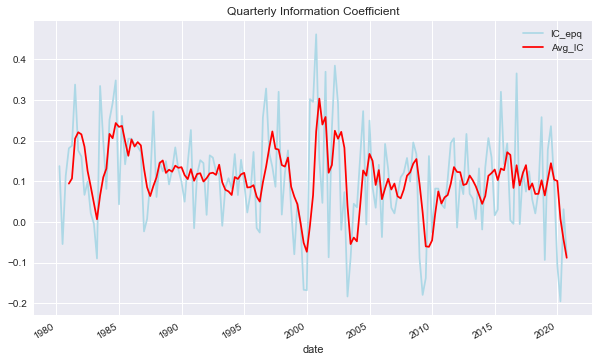

In [34]:
avg_ic3 = ic3.rolling(4).mean().rename('Avg_IC')
df3 = ic3.to_frame().join(avg_ic3)

df3.plot(figsize=(10, 6),
         color={'IC_epq':'lightblue', 'Avg_IC':'red'},
         title='Quarterly Information Coefficient')

___
### Important Sidenote
All the functions that we will create in class have been **saved into our own subject Python module** called `apmodule`. The module is contained in the file `apmodule.py`. If you click on this file from inside Jupyter Lab you will be able to see that it is simply a series of functions.

This module will be very useful in your assignment and coding exercises because it will allow you to **use the functions without having to copy them** inside your notebook. We can **import the module** as any other package:

In [35]:
import apmodule as ap

And then we can **use the functions** by applying the **package nickname**:

In [36]:
ic3b = ap.ic_analysis(signal['epq'], returns['return'], frequency='quarterly')

Average IC: 0.106 

Percentage of Positive Periods: 0.816 

Percentage of Negative Periods: 0.184 

T-Stat: 11.164 P-Value: 0.0 



___
### Exercise 7.01
Now that we have an easy-to-use function to assess the predictive power of an information signal, let's put it to the test by looking at the [**Momentum** investment strategy](https://funds.aqr.com/funds/aqr-large-cap-momentum-style-fund). The fundamental idea of this strategy is that the stocks that have performed better in the last 3-12 months will tend to out-perform the market in the next 3-12 months. Basically the idea is that _short-term trends tend to continue_.

**STEP 1:** Load the data in the `MOM12.zip` file into a new variable called `new_signal`. The file **has the same format** as the E/P one used in this notebook, so you can use the same command and indexing. Have a look at the first few lines of the file.

In [37]:
new_signal = pd.read_csv('MOM12.zip', parse_dates=['date']).set_index(['id', 'date'])
new_signal.head()

mom12
id    date                
10001 1987-02-27  0.072900
      1987-03-31 -0.243971
      1987-04-30 -0.118392
      1987-05-29 -0.146535
      1987-06-30 -0.232286

**STEP 2:** Use the function `ic_analysis()` to calculate the **annual Information Coefficient** for the Momentum Factor. Save the results in a Series called `mom_ic12`.

In [38]:
mom_ic12 = ic_analysis(new_signal['mom12'], returns['return'], frequency='annual')

Average IC: 0.06 

Percentage of Positive Periods: 0.725 

Percentage of Negative Periods: 0.275 

T-Stat: 2.843 P-Value: 0.007 



**STEP 3:** Plot the annual IC using a bar graph.

<AxesSubplot:title={'center':'Annual Analysis - Momentum'}, xlabel='date'>

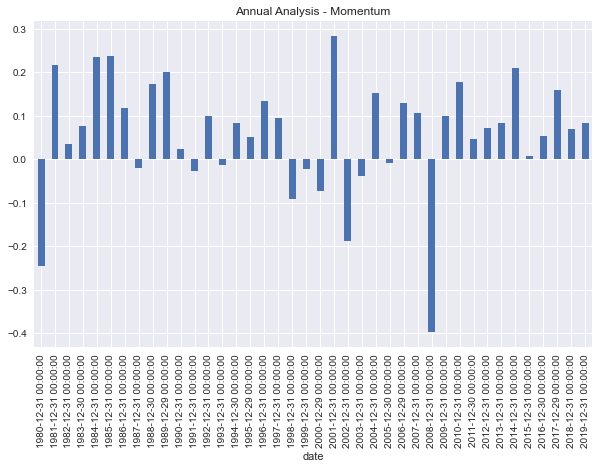

In [39]:
mom_ic12.plot(kind='bar',
              figsize=(10, 6),
              title='Annual Analysis - Momentum',
              legend=False)

**STEP 4:** Many investment strategies tend to combine both value and momentum. The idea is that these two factors tend to perform better in different periods of time. Can you see this in the two graphs? Are there periods where one factor has strong predicitve power while the other has a weak predicitve power?

You may realize that comparing the two plots visually **is not very easy**. We can do something more precise here. **Join** the annual momentum IC with the annual IC of the value factor (contained in `ic12`) into a single DataFrame called `ic_tot`. 

*HINT: remember that [**`DataFrame.join()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) only works for DataFrames, so you may have to transform one of the series into a DataFrame using [**`Series.to_frame()`**](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_frame.html) as we have done in the code. Show the first few lines of the new DataFrame.*

In [40]:
ic_tot = ic12.to_frame().join(mom_ic12)
ic_tot.head()

,IC,IC_mom12
date,,
1980-12-31,0.319429,-0.244746
1981-12-31,0.112603,0.216938
1982-12-31,0.100832,0.035553
1983-12-30,0.346851,0.076989
1984-12-31,0.214430,0.234704


**STEP 5:** Now that the two series are in the same frame we can easily calculate the linear correlation coefficient between the two using [**`DataFrame.corr()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html). Remember that for "linear" correlation we need to use `pearson` as the parameter. Does the result matches your expectations from the visual inspection of the graph? You should find a **positive, but weak, correlation**.

In [41]:
ic_tot.corr(method='pearson')

,IC,IC_mom12
IC,1.000000,0.321235
IC_mom12,0.321235,1.000000


**STEP 6:** What we would like to know is if there are years where one of the strategy would underperform (negative IC) while the other would outperform the market (positive IC. To do this plot **a bar graph of both variables** together. 

<AxesSubplot:title={'center':'IC Analysis - Value vs Momentum'}, xlabel='date'>

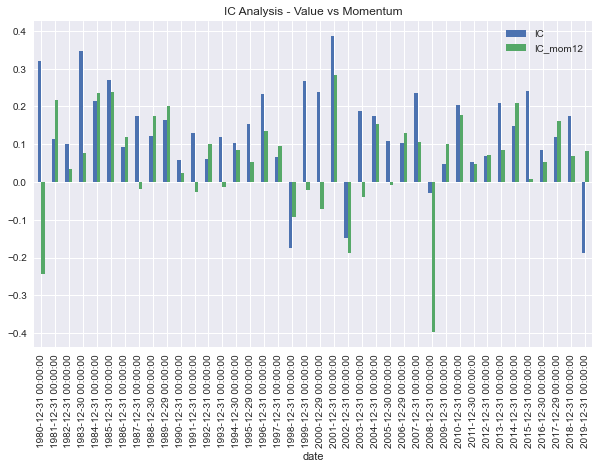

In [42]:
ic_tot.plot(kind='bar',
            figsize=(10, 6),
            title='IC Analysis - Value vs Momentum',
            legend=True)